C:\Users\Jerry\AppData\Local\Temp\ipykernel_24868\3122305841.py:127: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 128)


                                                          ST   ST_conf
Negative electrode thickness [m]                    0.000100  0.000036
Positive electrode thickness [m]                    0.101072  0.026732
Separator thickness [m]                             0.000000  0.000000
Negative electrode active material volume fraction  0.000040  0.000013
Positive electrode active material volume fraction  0.556765  0.139199
Negative particle radius [m]                        0.000037  0.000013
Positive particle radius [m]                        0.126326  0.030120
Initial concentration in electrolyte [mol.m-3]      0.000000  0.000000
Negative electrode conductivity [S.m-1]             0.000000  0.000000
Positive electrode conductivity [S.m-1]             0.000000  0.000000
Negative electrode Bruggeman coefficient (elect...  0.000000  0.000000
Positive electrode Bruggeman coefficient (elect...  0.000000  0.000000
Separator Bruggeman coefficient (electrolyte)       0.000000  0.000000
Maximu

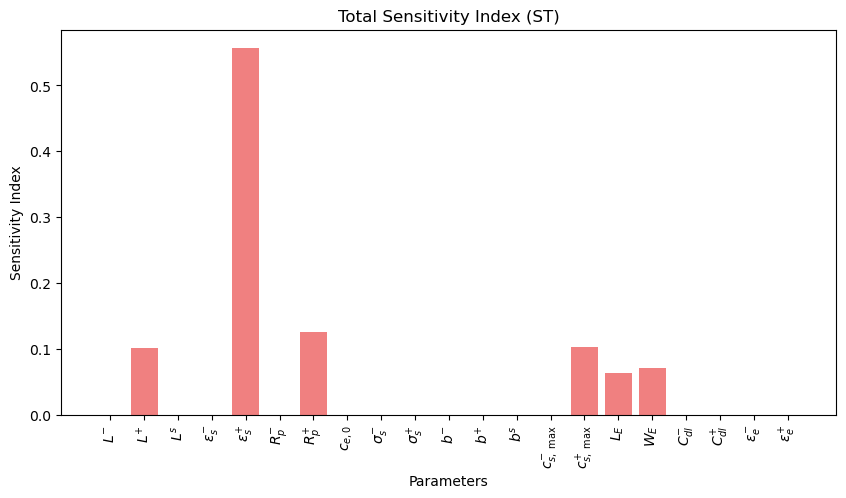

In [1]:
import pybamm
import numpy as np
import pandas as pd
from SALib.sample import saltelli
from SALib.analyze import sobol
import matplotlib.pyplot as plt
from SALib.plotting.bar import plot as barplot
from scipy.interpolate import interp1d

def battery_model(parameters):
    model = pybamm.lithium_ion.SPM()  
    
    experiment = pybamm.Experiment(
        ["Rest for 0.1 s",
            "Discharge at 0.96 A for 147 s",
            "Rest for 361 s",
            "Discharge at 0.96 A for 134 s"
        ],period = "10 second"
    )
    
    param = pybamm.ParameterValues("OKane2022")
    param["Separator porosity"] = 0.5
    param.update({
        "Negative electrode thickness [m]": parameters[0],
        "Positive electrode thickness [m]": parameters[1],
        "Separator thickness [m]": parameters[2],
        "Negative electrode active material volume fraction": parameters[3],
        "Positive electrode active material volume fraction": parameters[4],
        "Negative particle radius [m]": parameters[5],
        "Positive particle radius [m]": parameters[6],
        "Initial concentration in electrolyte [mol.m-3]": parameters[7],
        "Negative electrode conductivity [S.m-1]": parameters[8],
        "Positive electrode conductivity [S.m-1]": parameters[9],
        "Negative electrode Bruggeman coefficient (electrode)": parameters[10],
        "Positive electrode Bruggeman coefficient (electrode)": parameters[11],
        "Separator Bruggeman coefficient (electrolyte)": parameters[12],
        "Maximum concentration in negative electrode [mol.m-3]": parameters[13],
        "Maximum concentration in positive electrode [mol.m-3]": parameters[14],
        "Electrode height [m]": parameters[15],
        "Electrode width [m]": parameters[16],
        "Negative electrode double-layer capacity [F.m-2]": parameters[17],
        "Positive electrode double-layer capacity [F.m-2]": parameters[18],
        "Negative electrode porosity": parameters[19],
        "Positive electrode porosity": parameters[20]
    })
    
    param["Initial concentration in negative electrode [mol.m-3]"] = 0.9*param["Maximum concentration in negative electrode [mol.m-3]"]
    # param["Initial concentration in positive electrode [mol.m-3]"] = 0.5*param["Maximum concentration in positive electrode [mol.m-3]"]

    solver = pybamm.CasadiSolver(
        mode="safe",
        atol=1e-8,
        rtol=1e-8,
        dt_max=1e-2
    )
    
    try:
        simulation = pybamm.Simulation(model, parameter_values=param, solver=solver, experiment=experiment)
        solution = simulation.solve(calc_esoh=False)
        voltage = solution["Terminal voltage [V]"].entries
        # Getting results
        time = solution["Time [s]"].entries
        voltage = solution["Terminal voltage [V]"].entries
        
        
        # Generate a new point in time using np.logspace
        start = 0.1
        end = 147
        num_points = 5
        
        # Generate logspace time points and make sure they are within the simulated time range
        x = np.array([0])  # Initialize the time array
        x = np.append(
            x, np.logspace(np.log10(start), np.log10(end), num=num_points, endpoint=True)
        )
        x = np.append(
            x, np.logspace(np.log10(148), np.log10(508), num=num_points, endpoint=True)
        )
        # Ensure that the new point in time does not exceed the maximum time of the simulation
        max_time = time[-1]
        x = x[x <= max_time]
        
        # Calculate the new voltage value using the interpolation function
        interp_func = interp1d(time, voltage, kind='linear', fill_value="extrapolate")
        voltage_interp = interp_func(x)
        
        df = pd.DataFrame({'Time [s]': x, 'Voltage [V]': voltage_interp})
        return voltage_interp[-1]
    except pybamm.SolverError as e:
        print(f"Error: {e}")
        return np.nan
    
    # Defining the parameter space
problem = {
    'num_vars': 21,
    'names': [
        'Negative electrode thickness [m]', 
        'Positive electrode thickness [m]', 
        'Separator thickness [m]',
        'Negative electrode active material volume fraction',
        'Positive electrode active material volume fraction',
        'Negative particle radius [m]',
        'Positive particle radius [m]',
        'Initial concentration in electrolyte [mol.m-3]',
        'Negative electrode conductivity [S.m-1]',
        'Positive electrode conductivity [S.m-1]',
        'Negative electrode Bruggeman coefficient (electrode)',
        'Positive electrode Bruggeman coefficient (electrode)',
        'Separator Bruggeman coefficient (electrolyte)',
        'Maximum concentration in negative electrode [mol.m-3]',
        'Maximum concentration in positive electrode [mol.m-3]',
        'Electrode height [m]',
        'Electrode width [m]',
        'Negative electrode double-layer capacity [F.m-2]',
        'Positive electrode double-layer capacity [F.m-2]',
        'Negative electrode porosity',
        'Positive electrode porosity'
    ],
    'bounds': [
        [9e-5, 10e-5], [9e-5, 10e-5], [2e-5, 2.5e-5], [0.6, 0.65], [0.35, 0.45], 
        [1.5e-5, 1.7e-5], [1.5e-5, 1.7e-5], [1.1e3, 1.15e3], [1.5e2, 1.7e2], [12, 13], 
        [1.4, 1.6], [1.4, 1.6], [1.4, 1.6], [2.5e4, 2.8e4], [5.1e4, 5.2e4], 
        [0.12, 0.13], [0.22, 0.24], [0.3, 0.5], [0.3, 0.5], [0.3, 0.4], [0.3, 0.4]
    ]
}

param_values = saltelli.sample(problem, 128)

# Run the model and get the results
Y = []

for i, params in enumerate(param_values):
    try:
        result = battery_model(params)
        Y.append(result)
    except Exception as e:
        print(f"Error for sample {i} with parameters {params}: {e}")
        Y.append(np.nan)  # Returns NaN to continue processing other combinations of parameters

# Converting Y to a NumPy array and filtering NaN values
Y = np.array(Y)
valid_indices = ~np.isnan(Y)
Y_valid = Y[valid_indices]
param_values_valid = param_values[valid_indices]

Si = sobol.analyze(problem, Y_valid, print_to_console=True)

categories = [r'$L^{-}$',
              r'$L^{+}$',
              r'$L^{s}$',
              r'$\varepsilon_s^{-}$',
              r'$\varepsilon_s^{+}$',
              r'$R_p^{-}$',
              r'$R_p^{+}$',
              r'$c_{e, 0}$',
              r'$\sigma_s^{-}$',
              r'$\sigma_s^{+}$',
              r'$b^{-}$',
              r'$b^{+}$',
              r'$b^{s}$',
              r'$c_{s, \text { max }}^{-}$',
              r'$c_{s, \text { max }}^{+}$',
              r'$L_{E}$',
              r'$W_{E}$',
              r'$C_{dl}^{-}$',
              r'$C_{dl}^{+}$',
              r'$\varepsilon_e^{-}$',
              r'$\varepsilon_e^{+}$'
              ]

params = categories
# Total sensitivity index
plt.figure(figsize=(10, 5))
plt.bar(params, Si['ST'], color='lightcoral')
plt.title('Total Sensitivity Index (ST)')
plt.xlabel('Parameters')
plt.ylabel('Sensitivity Index')
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees
plt.show()

                                                          ST   ST_conf
Negative electrode thickness [m]                    0.000100  0.000036
Positive electrode thickness [m]                    0.101072  0.022074
Separator thickness [m]                             0.000000  0.000000
Negative electrode active material volume fraction  0.000040  0.000014
Positive electrode active material volume fraction  0.556765  0.132092
Negative particle radius [m]                        0.000037  0.000015
Positive particle radius [m]                        0.126326  0.036114
Initial concentration in electrolyte [mol.m-3]      0.000000  0.000000
Negative electrode conductivity [S.m-1]             0.000000  0.000000
Positive electrode conductivity [S.m-1]             0.000000  0.000000
Negative electrode Bruggeman coefficient (elect...  0.000000  0.000000
Positive electrode Bruggeman coefficient (elect...  0.000000  0.000000
Separator Bruggeman coefficient (electrolyte)       0.000000  0.000000
Maximu

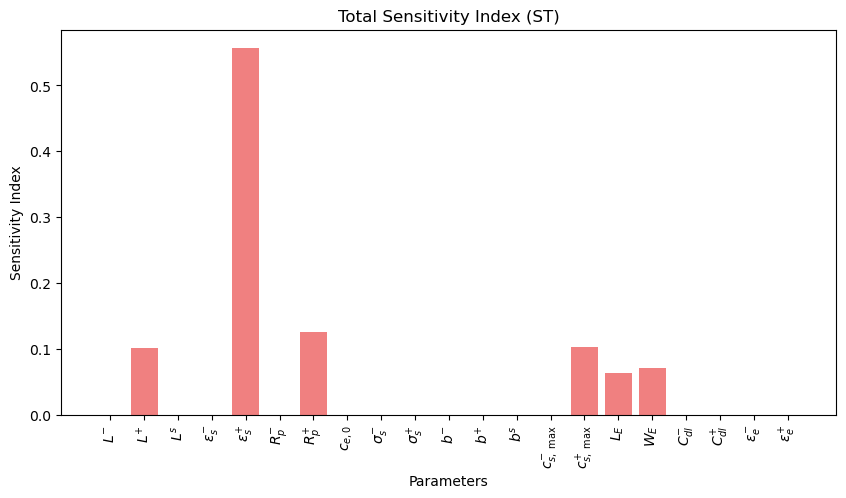

In [2]:
import pybamm
import numpy as np
import pandas as pd
from SALib.sample import saltelli
from SALib.analyze import sobol
import matplotlib.pyplot as plt
from SALib.plotting.bar import plot as barplot
from scipy.interpolate import interp1d

def battery_model(parameters):
    model = pybamm.lithium_ion.SPM()  
    
    experiment = pybamm.Experiment(
        ["Rest for 0.1 s",
            "Discharge at 0.96 A for 147 s",
            "Rest for 361 s",
            "Discharge at 0.96 A for 134 s"
        ],period = "10 second"
    )
    
    param = pybamm.ParameterValues("OKane2022")
    # param["Separator porosity"] = 0.5
    param.update({
        "Negative electrode thickness [m]": parameters[0],
        "Positive electrode thickness [m]": parameters[1],
        "Separator thickness [m]": parameters[2],
        "Negative electrode active material volume fraction": parameters[3],
        "Positive electrode active material volume fraction": parameters[4],
        "Negative particle radius [m]": parameters[5],
        "Positive particle radius [m]": parameters[6],
        "Initial concentration in electrolyte [mol.m-3]": parameters[7],
        "Negative electrode conductivity [S.m-1]": parameters[8],
        "Positive electrode conductivity [S.m-1]": parameters[9],
        "Negative electrode Bruggeman coefficient (electrode)": parameters[10],
        "Positive electrode Bruggeman coefficient (electrode)": parameters[11],
        "Separator Bruggeman coefficient (electrolyte)": parameters[12],
        "Maximum concentration in negative electrode [mol.m-3]": parameters[13],
        "Maximum concentration in positive electrode [mol.m-3]": parameters[14],
        "Electrode height [m]": parameters[15],
        "Electrode width [m]": parameters[16],
        "Negative electrode double-layer capacity [F.m-2]": parameters[17],
        "Positive electrode double-layer capacity [F.m-2]": parameters[18],
        "Negative electrode porosity": parameters[19],
        "Positive electrode porosity": parameters[20]
    })
    
    param["Initial concentration in negative electrode [mol.m-3]"] = 0.9*param["Maximum concentration in negative electrode [mol.m-3]"]
    # param["Initial concentration in positive electrode [mol.m-3]"] = 0.5*param["Maximum concentration in positive electrode [mol.m-3]"]

    solver = pybamm.CasadiSolver(
        mode="safe",
        atol=1e-8,
        rtol=1e-8,
        dt_max=1e-2
    )
    
    try:
        simulation = pybamm.Simulation(model, parameter_values=param, solver=solver, experiment=experiment)
        solution = simulation.solve(calc_esoh=False)
        voltage = solution["Terminal voltage [V]"].entries
        # Getting results
        time = solution["Time [s]"].entries
        voltage = solution["Terminal voltage [V]"].entries
        
        
        # Generate a new point in time using np.logspace
        start = 0.1
        end = 147
        num_points = 5
        
        # Generate logspace time points and make sure they are within the simulated time range
        x = np.array([0])  # Initialize the time array
        x = np.append(
            x, np.logspace(np.log10(start), np.log10(end), num=num_points, endpoint=True)
        )
        x = np.append(
            x, np.logspace(np.log10(148), np.log10(508), num=num_points, endpoint=True)
        )
        # Ensure that the new point in time does not exceed the maximum time of the simulation
        max_time = time[-1]
        x = x[x <= max_time]
        
        # Calculate the new voltage value using the interpolation function
        interp_func = interp1d(time, voltage, kind='linear', fill_value="extrapolate")
        voltage_interp = interp_func(x)
        
        df = pd.DataFrame({'Time [s]': x, 'Voltage [V]': voltage_interp})
        return voltage_interp[-1]
    except pybamm.SolverError as e:
        print(f"Error: {e}")
        return np.nan
    
    # Defining the parameter space
problem = {
    'num_vars': 21,
    'names': [
        'Negative electrode thickness [m]', 
        'Positive electrode thickness [m]', 
        'Separator thickness [m]',
        'Negative electrode active material volume fraction',
        'Positive electrode active material volume fraction',
        'Negative particle radius [m]',
        'Positive particle radius [m]',
        'Initial concentration in electrolyte [mol.m-3]',
        'Negative electrode conductivity [S.m-1]',
        'Positive electrode conductivity [S.m-1]',
        'Negative electrode Bruggeman coefficient (electrode)',
        'Positive electrode Bruggeman coefficient (electrode)',
        'Separator Bruggeman coefficient (electrolyte)',
        'Maximum concentration in negative electrode [mol.m-3]',
        'Maximum concentration in positive electrode [mol.m-3]',
        'Electrode height [m]',
        'Electrode width [m]',
        'Negative electrode double-layer capacity [F.m-2]',
        'Positive electrode double-layer capacity [F.m-2]',
        'Negative electrode porosity',
        'Positive electrode porosity'
    ],
    'bounds': [
        [9e-5, 10e-5], [9e-5, 10e-5], [2e-5, 2.5e-5], [0.6, 0.65], [0.35, 0.45], 
        [1.5e-5, 1.7e-5], [1.5e-5, 1.7e-5], [1.1e3, 1.15e3], [1.5e2, 1.7e2], [12, 13], 
        [1.4, 1.6], [1.4, 1.6], [1.4, 1.6], [2.5e4, 2.8e4], [5.1e4, 5.2e4], 
        [0.12, 0.13], [0.22, 0.24], [0.3, 0.5], [0.3, 0.5], [0.3, 0.4], [0.3, 0.4]
    ]
}

param_values = saltelli.sample(problem, 128)

# Run the model and get the results
Y = []

for i, params in enumerate(param_values):
    try:
        result = battery_model(params)
        Y.append(result)
    except Exception as e:
        print(f"Error for sample {i} with parameters {params}: {e}")
        Y.append(np.nan)  # Returns NaN to continue processing other combinations of parameters

# Converting Y to a NumPy array and filtering NaN values
Y = np.array(Y)
valid_indices = ~np.isnan(Y)
Y_valid = Y[valid_indices]
param_values_valid = param_values[valid_indices]

Si = sobol.analyze(problem, Y_valid, print_to_console=True)

categories = [r'$L^{-}$',
              r'$L^{+}$',
              r'$L^{s}$',
              r'$\varepsilon_s^{-}$',
              r'$\varepsilon_s^{+}$',
              r'$R_p^{-}$',
              r'$R_p^{+}$',
              r'$c_{e, 0}$',
              r'$\sigma_s^{-}$',
              r'$\sigma_s^{+}$',
              r'$b^{-}$',
              r'$b^{+}$',
              r'$b^{s}$',
              r'$c_{s, \text { max }}^{-}$',
              r'$c_{s, \text { max }}^{+}$',
              r'$L_{E}$',
              r'$W_{E}$',
              r'$C_{dl}^{-}$',
              r'$C_{dl}^{+}$',
              r'$\varepsilon_e^{-}$',
              r'$\varepsilon_e^{+}$'
              ]

params = categories
# Total sensitivity index
plt.figure(figsize=(10, 5))
plt.bar(params, Si['ST'], color='lightcoral')
plt.title('Total Sensitivity Index (ST)')
plt.xlabel('Parameters')
plt.ylabel('Sensitivity Index')
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees
plt.show()